In [1]:
import sys
sys.path.append('/home/shiftpub/Dynamic_AMM/inf_step_exp')

from parametric import ParametricValueModel

model = ParametricValueModel(L = 100, mu=0.0, sigma=0.2, gamma=0.003, delta_t=1)

In [ ]:
import pandas as pd

state_df = model.generate_raw_data(num_samples=10)
print(state_df.to_markdown())

---

## Single State Demonstration

$$C^{(k)} \cdot \sqrt{p_0} = max\left(p_0\cdot x_0 + y_0, E[Fee + C^{(k)} \cdot \sqrt{p_1}]\right)$$

In [ ]:
import pandas as pd

selected_state = state_df.iloc[3]
print(f"Selected state:\n {selected_state}")


In [ ]:
new_points, raw_weights, pdf, weights = model.generate_trapezoidal_points(selected_state['p'], num_points=10)

new_state = pd.DataFrame({
    'p1': new_points,
    'adj.W': weights,
    'raw_weights': raw_weights,
    'pdf': pdf
})
print(f"\nNew state:\n {new_state.to_markdown()}")

In [ ]:
for i, row in new_state.iterrows():
    new_states = model.calculate_future_states(selected_state, integration_points=row['p1'])
    new_state.loc[i, 'new_x'] = new_states['new_x']
    new_state.loc[i, 'new_y'] = new_states['new_y']
    

print(new_state.to_markdown())

In [ ]:
import numpy as np

# Incoming Fee

integrated_df = new_state[['p1', 'adj.W']].copy()
integrated_df.loc[:, 'p0'] = selected_state['p']
integrated_df.loc[:, 'fee'] = selected_state['fin']

# initialize C
C = 1.0

# calculate the right hand side
integrated_df.loc[:, 'C'] = C

integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + integrated_df['C'] * np.sqrt(integrated_df['p1'])
print(integrated_df.to_markdown())

exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()

print(f"\nWeighted Continuation Value for incoming fee: {exp_inc_cont}")


In [ ]:
results_df = pd.DataFrame([selected_state])
results_df.loc[:, 'C'] = C
results_df.loc[:, 'expected_inc_cont'] = exp_inc_cont

print(results_df.to_markdown())

In [ ]:
from scipy.optimize import minimize

def objective_in(c):
    new_points, raw_weights, pdf, weights = model.generate_trapezoidal_points(selected_state['p'], num_points=10)

    new_state = pd.DataFrame({
        'p1': new_points,
        'adj.W': weights,
        'raw_weights': raw_weights,
        'pdf': pdf
    })
    # Generate data with the given C value
    integrated_df = new_state[['p1', 'adj.W']].copy()
    integrated_df.loc[:, 'p0'] = selected_state['p']
    integrated_df.loc[:, 'fee'] = selected_state['fin']
    integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + c * np.sqrt(integrated_df['p1'])
    
    exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()
    max_value = np.maximum(selected_state['current_pool'], exp_inc_cont)
    lhs_value = c * np.sqrt(selected_state['p'])
    error = np.abs(max_value - lhs_value)
    return error

# Optimize C
C_opt = minimize(objective_in, x0=1.0, method='Nelder-Mead')
print(f"Optimal C: {C_opt.x[0]}")


In [ ]:
results_df = pd.DataFrame([selected_state])
results_df.loc[:, 'C'] = C_opt.x[0]
integrated_df.loc[:, 'C'] = C_opt.x[0]
integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + integrated_df['C'] * np.sqrt(integrated_df['p1'])
print(f"next state:\n {integrated_df.to_markdown()}")
exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()
print(f"\nexpected continuation value with optimal C: {exp_inc_cont}\n")
results_df.loc[:, 'expected_inc_cont'] = exp_inc_cont
print(f"results df:\n {results_df.to_markdown()}")

---

## Multiple State Demonstration

In [ ]:
import pandas as pd

state_df = model.generate_raw_data(num_samples=10)
print(state_df.to_markdown())

In [ ]:
from scipy.optimize import minimize

def objective_in(c):
    error = 0
    
    for i, row in state_df.iterrows():
        # Generate data with the given C value
        integrated_df = new_state[['p1', 'adj.W']].copy()
        integrated_df.loc[:, 'p0'] = selected_state['p']
        integrated_df.loc[:, 'fee'] = selected_state['fin']
        integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + c * np.sqrt(integrated_df['p1'])
        
        exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()
        max_value = np.maximum(selected_state['current_pool'], exp_inc_cont)
        lhs_value = c * np.sqrt(selected_state['p'])
        error = np.abs(max_value - lhs_value)
    return error

# Optimize C
C_opt = minimize(objective_in, x0=1.0, method='Nelder-Mead')
print(f"Optimal C: {C_opt.x[0]}")


In [ ]:
from parametric import ParametricValueModel

model = ParametricValueModel(L=100,mu=0.0, sigma=0.2, gamma=0.003, delta_t=1)

parametric_df, se = model.generate_parametric_data(Cin=1.0, Cout=1.0, num_samples=1, num_integration_points=10)

print(parametric_df.to_markdown())

In [ ]:
optimal_cin, optimal_cout, optimal_data, se = model.find_optimal_c_in_out(num_samples=100, num_integration_points=100, initial_c=1.0)

print(optimal_data.head().to_markdown())

Parameter K is in [-1, 1], determining the relative position for the initial price P0

In [ ]:
import sys
sys.path.append('/home/shiftpub/Dynamic_AMM/inf_step_exp')

from parametric import ParametricValueModel

k = 1
dt = 1/365*1/24*1/60*10/60
model = ParametricValueModel(L=100,mu=0.0, sigma=0.2, gamma=0.003, delta_t=dt)

parametric_df = model.generate_parametric_data(Cin=1.0, Cout=1.0, k=k, num_samples=1, num_integration_points=10)

optimal_cin, optimal_cout, optimal_data, se= model.find_optimal_c_in_out(k=k, num_samples=100, num_integration_points=100, initial_c=1.0)

print(optimal_data.head().to_markdown())

---

## Single State Demonstration without Maximum Operator

$$C^{(k)} \cdot \sqrt{p_0} = E[Fee + C^{(k)} \cdot \sqrt{p_1}]$$

In [ ]:
import pandas as pd

state_df = model.generate_raw_data(num_samples=10)
print(state_df.to_markdown())

In [ ]:
import pandas as pd

selected_state = state_df.iloc[3]
print(f"Selected state:\n {selected_state}")


In [ ]:
new_points, raw_weights, pdf, weights = model.generate_trapezoidal_points(selected_state['p'], num_points=10)

new_state = pd.DataFrame({
    'p1': new_points,
    'adj.W': weights,
    'raw_weights': raw_weights,
    'pdf': pdf
})
print(f"\nNew state:\n {new_state.to_markdown()}")

In [ ]:
for i, row in new_state.iterrows():
    new_states = model.calculate_future_states(selected_state, integration_points=row['p1'])
    new_state.loc[i, 'new_x'] = new_states['new_x']
    new_state.loc[i, 'new_y'] = new_states['new_y']
    

print(new_state.to_markdown())

In [ ]:
import numpy as np

# Incoming Fee

integrated_df = new_state[['p1', 'adj.W']].copy()
integrated_df.loc[:, 'p0'] = selected_state['p']
integrated_df.loc[:, 'fee'] = selected_state['fin']

# initialize C
C = 1.0

# calculate the right hand side
integrated_df.loc[:, 'C'] = C

integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + integrated_df['C'] * np.sqrt(integrated_df['p1'])
print(integrated_df.to_markdown())

exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()

print(f"\nWeighted Continuation Value for incoming fee: {exp_inc_cont}")


In [ ]:
results_df = pd.DataFrame([selected_state])
results_df.loc[:, 'C'] = C
results_df.loc[:, 'expected_inc_cont'] = exp_inc_cont

print(results_df.to_markdown())

In [ ]:
from scipy.optimize import minimize

def objective_in(c):
    new_points, raw_weights, pdf, weights = model.generate_trapezoidal_points(selected_state['p'], num_points=10)

    new_state = pd.DataFrame({
        'p1': new_points,
        'adj.W': weights,
        'raw_weights': raw_weights,
        'pdf': pdf
    })
    # Generate data with the given C value
    integrated_df = new_state[['p1', 'adj.W']].copy()
    integrated_df.loc[:, 'p0'] = selected_state['p']
    integrated_df.loc[:, 'fee'] = selected_state['fin']
    integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + c * np.sqrt(integrated_df['p1'])
    
    exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()
    # max_value = np.maximum(selected_state['current_pool'], exp_inc_cont)
    lhs_value = c * np.sqrt(selected_state['p'])
    error = np.abs(exp_inc_cont - lhs_value) # instead of using max value, we use continuation value
    return error

# Optimize C
C_opt = minimize(objective_in, x0=1.0, method='Nelder-Mead')
print(f"Optimal C: {C_opt.x[0]}")


In [ ]:
results_df = pd.DataFrame([selected_state])
results_df.loc[:, 'C'] = C_opt.x[0]
integrated_df.loc[:, 'C'] = C_opt.x[0]
integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + integrated_df['C'] * np.sqrt(integrated_df['p1'])
print(f"next state:\n {integrated_df.to_markdown()}")
exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()
print(f"\nexpected continuation value with optimal C: {exp_inc_cont}\n")
results_df.loc[:, 'expected_inc_cont'] = exp_inc_cont
print(f"results df:\n {results_df.to_markdown()}")

In [ ]:
import numpy as np

fee = 0.000018
p0 = 1
sigma = 0.2
gamma = 0.003
delta_t = 1/365*1/24*1/60*10/60
print(delta_t)

c = fee / (np.sqrt(p0) * (1- np.exp(-1/8 * sigma**2 * delta_t)))
print(c)

---

## Multiple State Demonstration without Maximum

In [ ]:
import pandas as pd

state_df = model.generate_raw_data(num_samples=10)
print(state_df.to_markdown())

In [ ]:
from scipy.optimize import minimize

def objective_in(c):
    error = 0
    
    for i, row in state_df.iterrows():
        # Generate data with the given C value
        integrated_df = new_state[['p1', 'adj.W']].copy()
        integrated_df.loc[:, 'p0'] = selected_state['p']
        integrated_df.loc[:, 'fee'] = selected_state['fin']
        integrated_df.loc[:, 'rhs_cont'] = integrated_df['fee'] + c * np.sqrt(integrated_df['p1'])
        
        exp_inc_cont = (integrated_df['rhs_cont'] * integrated_df['adj.W']).sum()
        # max_value = np.maximum(selected_state['current_pool'], exp_inc_cont)
        lhs_value = c * np.sqrt(selected_state['p'])
        error = np.abs(exp_inc_cont - lhs_value) # instead of using max value, we use continuation value
    return error

# Optimize C
C_opt = minimize(objective_in, x0=1.0, method='Nelder-Mead')
print(f"Optimal C: {C_opt.x[0]}")


In [ ]:
from parametric import ParametricValueModel

model = ParametricValueModel(L=100,mu=0.0, sigma=0.2, gamma=0.003, delta_t=1)

parametric_df, se = model.generate_parametric_data(Cin=1.0, Cout=1.0, num_samples=100, num_integration_points=10)

print(parametric_df.head().to_markdown())

In [ ]:
optimal_cin, optimal_cout, optimal_data, se = model.find_optimal_c_in_out(num_samples=10, num_integration_points=10, initial_c=1.0, maximum=False)

print(optimal_data.head().to_markdown())

In [ ]:
from parametric import ParametricValueModel
import pandas as pd

L = 100
mu = 0.0
sigma = 0.2
gamma = 0.003
delta_t = 1


results = []

for L in [100]:
    for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
        for gamma in [0.001, 0.002, 0.003, 0.004, 0.005]:
            for delta_t in [0.000001, 0.001, 0.01, 0.1, 1]:

                model = ParametricValueModel(L=L,mu=mu, sigma=sigma, gamma=gamma, delta_t=delta_t)

                parametric_df = model.generate_raw_data(num_samples=100)

                parametric_df.loc[:, 'L'] = L

                parametric_df.loc[:, 'lfs'] = 2 * parametric_df['L'] * np.sqrt(parametric_df['p']) * (1 - np.exp(-1/8 * sigma**2 * delta_t))

                # count how many rows lfs is greater than fin
                num_time_to_continue_in = (parametric_df['lfs'] < parametric_df['fin']).sum()
                num_time_to_continue_out = (parametric_df['lfs'] < parametric_df['fout']).sum()
                results.append({'L': L, 'sigma': sigma, 'gamma': gamma, 'delta_t': delta_t, 'num_time_to_continue_in': num_time_to_continue_in, 'num_time_to_continue_out': num_time_to_continue_out})

results_df = pd.DataFrame(results)

# print rows where num_time_to_continue is not 0
print(results_df[results_df['num_time_to_continue_in'] != 0].to_markdown())
print(results_df[results_df['num_time_to_continue_out'] != 0].to_markdown())



In [ ]:
L = 100
mu = 0.0
sigma = 0.1
gamma = 0.003
delta_t = 0.001

model = ParametricValueModel(L=L,mu=mu, sigma=sigma, gamma=gamma, delta_t=delta_t)

parametric_df = model.generate_raw_data(num_samples=1000)

parametric_df.loc[:, 'L'] = L

parametric_df.loc[:, 'lfs'] = 2 * parametric_df['L'] * np.sqrt(parametric_df['p']) * (1 - np.exp(-1/8 * sigma**2 * delta_t))

print(parametric_df.head().to_markdown())

p: [4.         2.25       1.44       1.         0.73469388 0.5625
 0.44444444 0.36       0.29752066 0.25      ], x: [ 50.          66.66666667  83.33333333 100.         116.66666667
 133.33333333 150.         166.66666667 183.33333333 200.        ], y: [200.         150.         120.         100.          85.71428571
  75.          66.66666667  60.          54.54545455  50.        ]
incoming_term1: [5.88262198e-10 4.41196649e-10 3.52957319e-10 2.94131099e-10
 2.52112371e-10 2.20598324e-10 1.96087399e-10 1.76478659e-10
 1.60435145e-10 1.47065550e-10], incoming_term2: [2.92103534e-10 2.19077651e-10 1.75262121e-10 1.46051767e-10
 1.25187229e-10 1.09538825e-10 9.73678448e-11 8.76310603e-11
 7.96646003e-11 7.30258836e-11], incoming_term3: [2.92103534e-10 2.19077651e-10 1.75262121e-10 1.46051767e-10
 1.25187229e-10 1.09538825e-10 9.73678448e-11 8.76310603e-11
 7.96646003e-11 7.30258836e-11]
incoming_fee: [4.05512952e-12 3.04134714e-12 2.43307771e-12 2.02756476e-12
 1.73791265e-12 1.52067357e

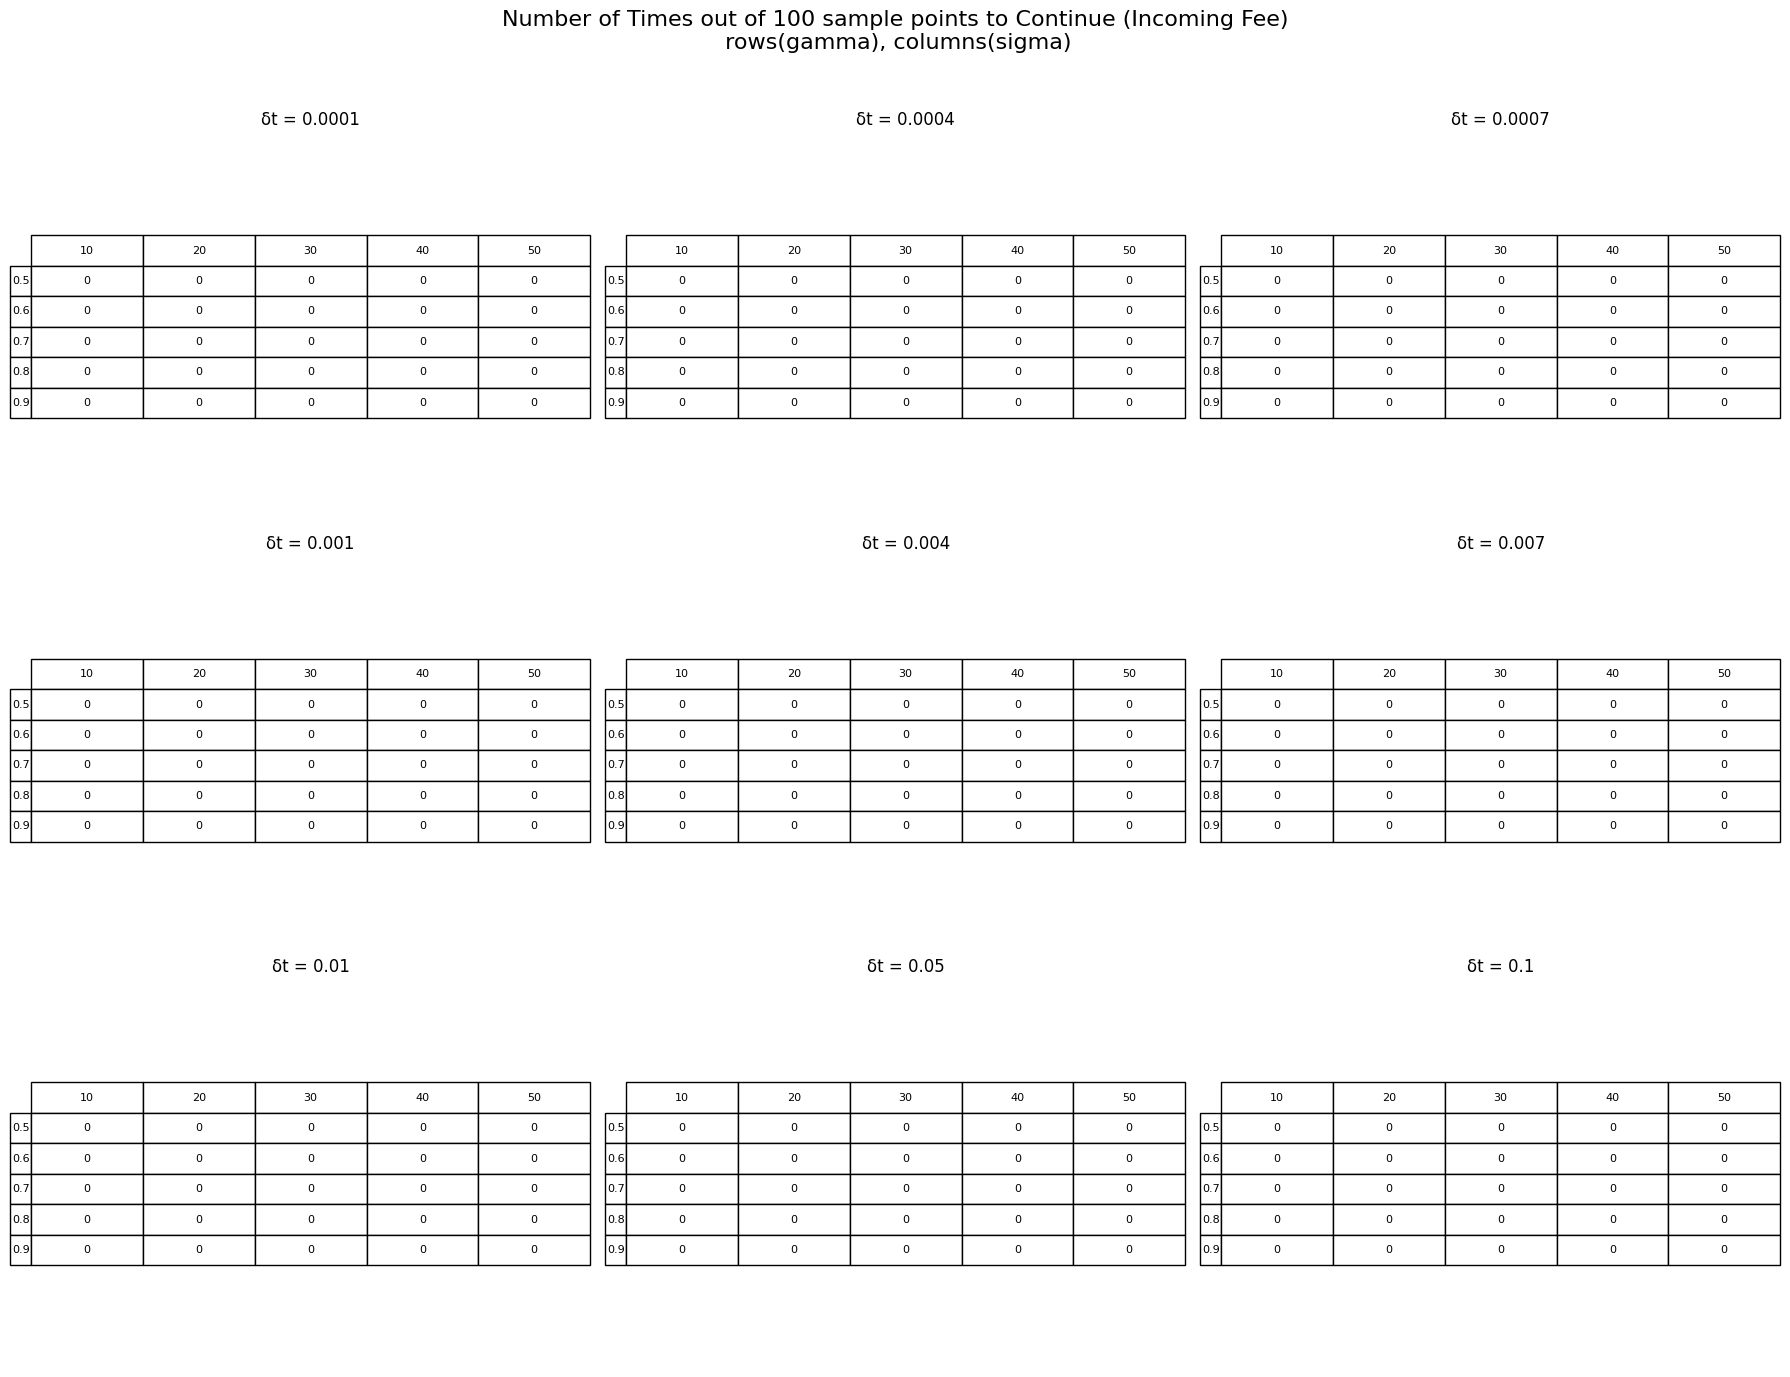

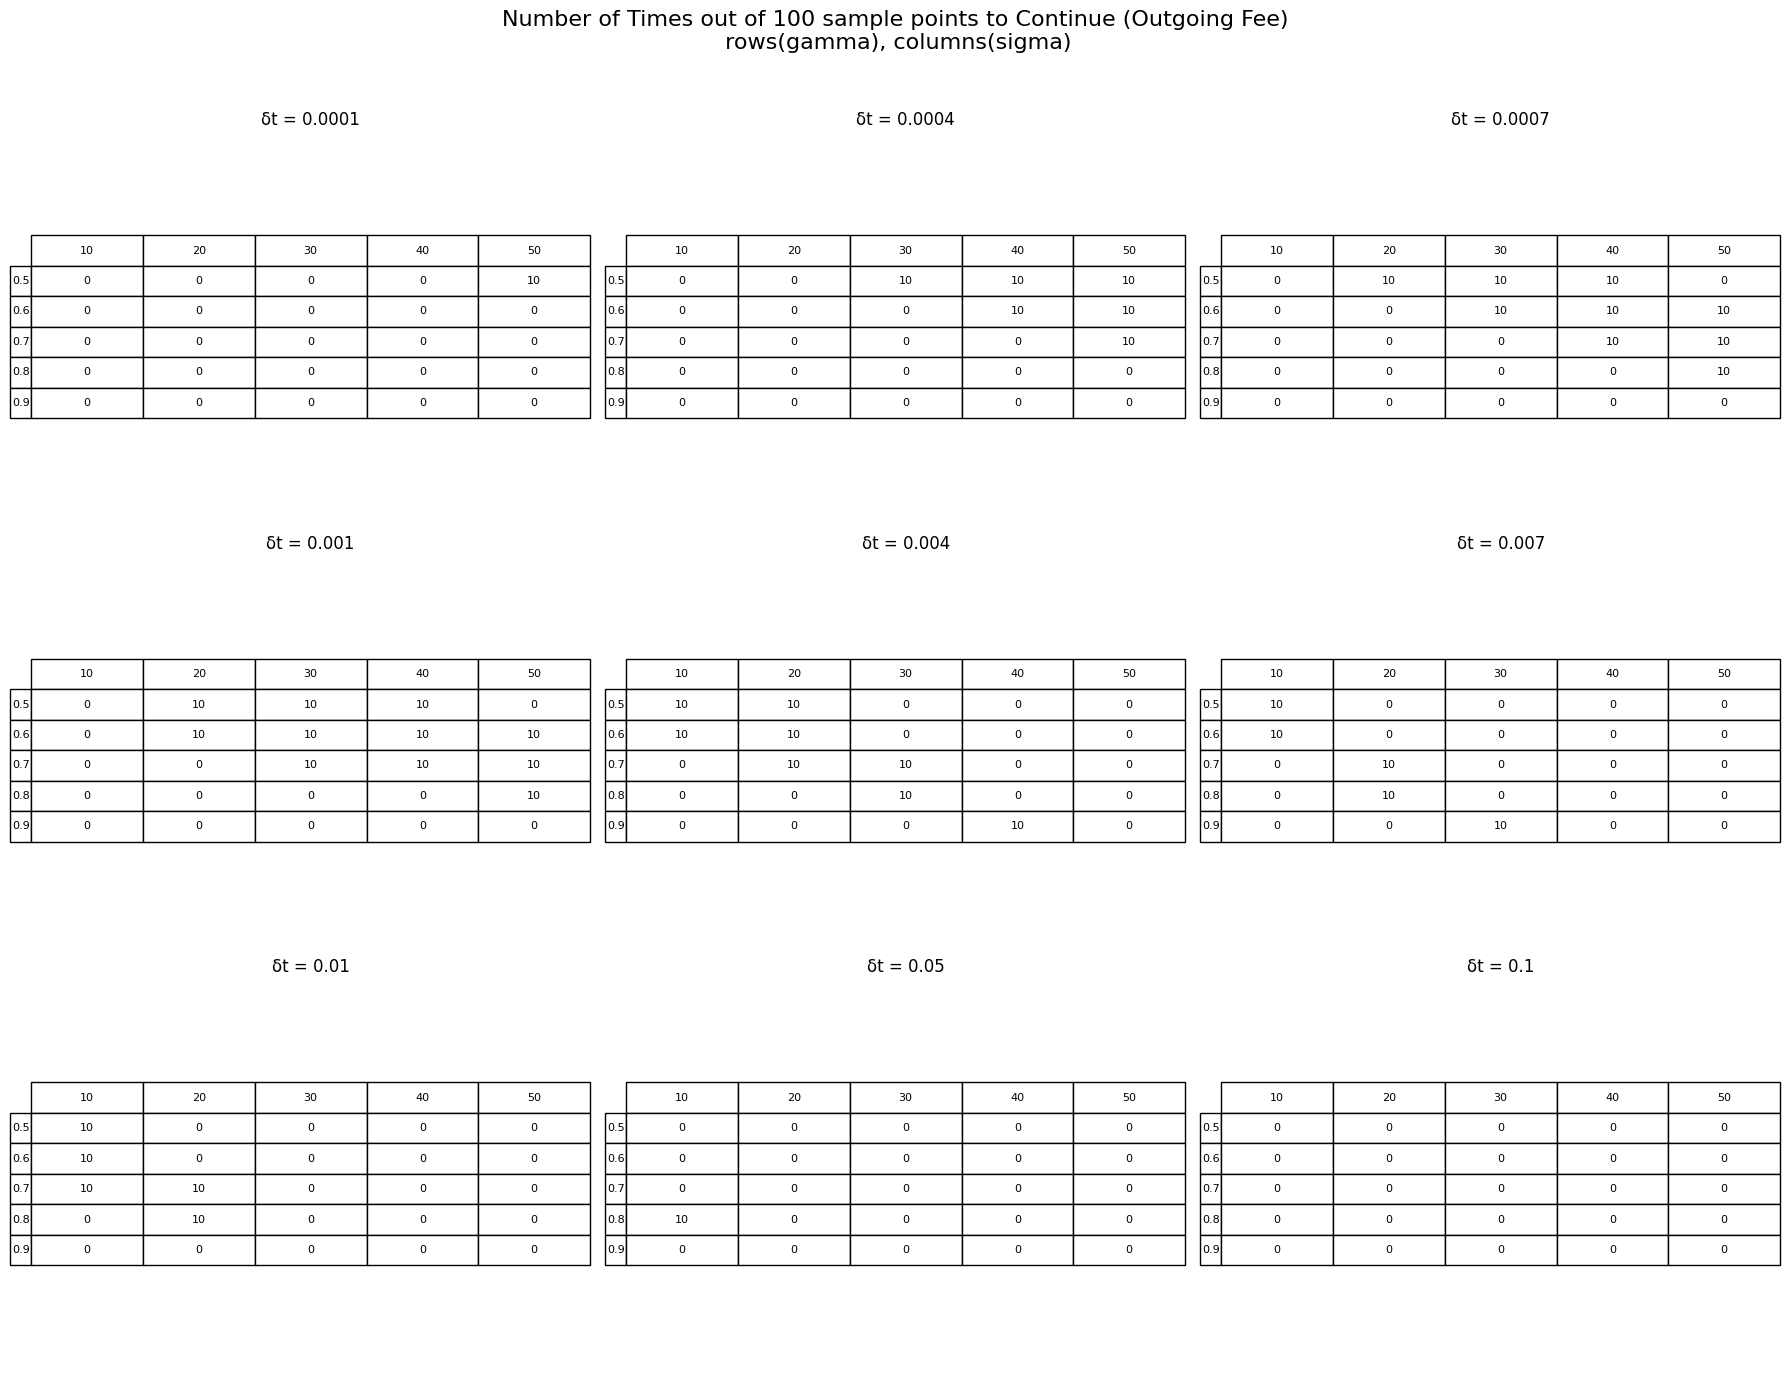

Tables created and saved as 'continue_in_tables.png' and 'continue_out_tables.png'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from parametric import ParametricValueModel
from matplotlib.gridspec import GridSpec

# Define parameter values
L = 100
mu = 0.0
sigma_values = [10, 20, 30, 40, 50]
gamma_values = [0.5, 0.6, 0.7, 0.8, 0.9]
delta_t_values = [0.0001, 0.0004, 0.0007, 0.001, 0.004, 0.007, 0.01, 0.05, 0.1]


# Run parameter sweep
results = []
for sigma in sigma_values:
    for gamma in gamma_values:
        for delta_t in delta_t_values:
            model = ParametricValueModel(L=L, mu=mu, sigma=sigma, gamma=gamma, delta_t=delta_t)
            parametric_df = model.generate_raw_data(k = 0, num_samples=10)
            parametric_df.loc[:, 'L'] = L
            parametric_df.loc[:, 'lfs'] = 2 * parametric_df['L'] * np.sqrt(parametric_df['p']) * (1 - np.exp(-1/8 * sigma**2 * delta_t))
            print(f"lhs: {parametric_df['lfs']} ")
            print(f"rhs: {parametric_df['fin']}")
            # Count how many rows lfs is less than fin/fout
            num_time_to_continue_in = (parametric_df['lfs'] < parametric_df['fin']).sum()
            num_time_to_continue_out = (parametric_df['lfs'] < parametric_df['fout']).sum()
            
            results.append({
                'sigma': sigma, 
                'gamma': gamma, 
                'delta_t': delta_t, 
                'continue_in': num_time_to_continue_in, 
                'continue_out': num_time_to_continue_out
            })

# Create DataFrame
results_df = pd.DataFrame(results)

# Function to create a single table plot
def plot_table(ax, data, title):
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=data.values,
        colLabels=data.columns,
        rowLabels=data.index,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    ax.set_title(title)

# Create a 3x3 grid of tables for continue_in
plt.figure(figsize=(18, 14))
plt.suptitle('Number of Times out of 100 sample points to Continue (Incoming Fee)\n rows(gamma), columns(sigma)', fontsize=16)
gs = GridSpec(3, 3)

for i, delta_t in enumerate(delta_t_values):
    row = i // 3
    col = i % 3
    
    ax = plt.subplot(gs[row, col])
    
    # Filter for current delta_t
    df_filtered = results_df[results_df['delta_t'] == delta_t]
    
    # Create pivot table
    pivot = pd.pivot_table(
        df_filtered,
        values='continue_in',
        index='gamma',
        columns='sigma'
    )
    
    # Plot table
    plot_table(ax, pivot, f'δt = {delta_t}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('continue_in_tables.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create a 3x3 grid of tables for continue_out
plt.figure(figsize=(18, 14))
plt.suptitle('Number of Times out of 100 sample points to Continue (Outgoing Fee)\n rows(gamma), columns(sigma)', fontsize=16)
gs = GridSpec(3, 3)

for i, delta_t in enumerate(delta_t_values):
    row = i // 3
    col = i % 3
    
    ax = plt.subplot(gs[row, col])
    
    # Filter for current delta_t
    df_filtered = results_df[results_df['delta_t'] == delta_t]
    
    # Create pivot table
    pivot = pd.pivot_table(
        df_filtered,
        values='continue_out',
        index='gamma',
        columns='sigma'
    )
    
    # Plot table
    plot_table(ax, pivot, f'δt = {delta_t}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('continue_out_tables.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Tables created and saved as 'continue_in_tables.png' and 'continue_out_tables.png'")

In [ ]:
import numpy as np

results = []
for gamma in np.linspace(0.001, 0.99, 10000):
    value = gamma / (np.sqrt(1-gamma))
    results.append({'gamma': gamma, 'value': value, '1-gamma': np.sqrt(1-gamma)})

results_df = pd.DataFrame(results)

plt.plot(results_df['gamma'], results_df['value'])
plt.show()

In [ ]:
import numpy as np

delta_t = 1/365/24/60/60
sigma = 0.2
print(np.exp(-1/8 * sigma**2 * 0.1))

In [ ]:
import numpy as np
import pandas as pd

results = []
for gamma in np.arange(0.0001, 0.999, 0.001):
    results.append({
        'gamma': gamma,
        'value': (gamma/(1-gamma)) * (np.sqrt(1-gamma) - 2)
    })
    
df = pd.DataFrame(results)

import matplotlib.pyplot as plt

plt.plot(df['gamma'], df['value'])
plt.show()

In [ ]:
import numpy as np
import pandas as pd

results = []
for gamma in np.arange(0.0001, 0.999, 0.001):
    results.append({
        'gamma': gamma,
        'value': (gamma / (2* np.sqrt(1-gamma))) - gamma
    })
    
df = pd.DataFrame(results)

import matplotlib.pyplot as plt

plt.plot(df['gamma'], df['value'])
plt.show()

In [ ]:
import numpy as np
import pandas as pd

results = []
for gamma in np.arange(0.0001, 0.999, 0.001):
    results.append({
        'gamma': gamma,
        'a': 2 * np.sqrt(1-gamma),
        'b': 1-gamma
    })
    
df = pd.DataFrame(results)

import matplotlib.pyplot as plt

plt.plot(df['gamma'], df['a'])
plt.plot(df['gamma'], df['b'])
plt.legend(['a', 'b'])
plt.show()

In [ ]:
from scipy.stats import norm
import numpy as np

y = 100
x = 100
p = 1
gamma = 0.5

sigma = 0.2
delta_t = 0.1

integrand  = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2

value = norm.cdf(integrand)

print(f"integrand: {integrand}")
print(f"value: {value}")

In [ ]:
from scipy.stats import norm
import numpy as np

y = 100
x = 100
p = 1
gamma = 0.5

sigma = 0.2
delta_t = 0.1

integrand  = np.log((1-gamma) * y/(p * x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2

value = norm.cdf(integrand)

print(f"integrand: {integrand}")
print(f"value: {value}")

In [ ]:
import numpy as np
from scipy.stats import norm


gamma = 0.5
sigma = 0.2
delta_t = 1

integrand_plus = np.log(1/(1-gamma)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
integrand_minus = np.log(1-gamma) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2

v_plus = norm.cdf(integrand_plus)
v_minus = norm.cdf(integrand_minus)

v = v_plus - v_minus

print(f"v: {v}")



maximum v: 9.936149927621616e-14


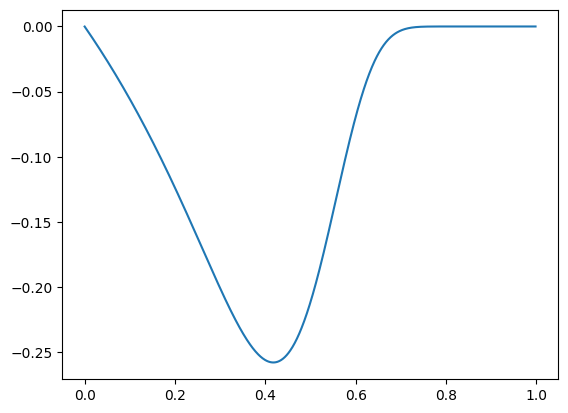

In [10]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


gamma = 0.5
sigma = 20
delta_t = 0.0001
k = -1
L = 100
x = 10
y = L**2 / x
p = (y/x) / (1-gamma)**(k)
results = []

for gamma in np.arange(0.0001, 0.999, 0.001):   

    A = np.exp(-1/8 * sigma**2 * delta_t)
    d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
    integrand_plus = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
    integrand_minus = np.log(y*(1-gamma)/(p*x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2
    term1 = 0.5 * A * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = norm.cdf(d1 - sigma * np.sqrt(delta_t) / 2) + norm.cdf(-d2 - sigma * np.sqrt(delta_t) / 2)

    v = gamma/(1-gamma) * (term1 - term2)

    results.append({'gamma': gamma, 'v': v})

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt
print(f"maximum v: {results_df['v'].max()}")
plt.plot(results_df['gamma'], results_df['v'])
plt.show()


maximum v: 0.0


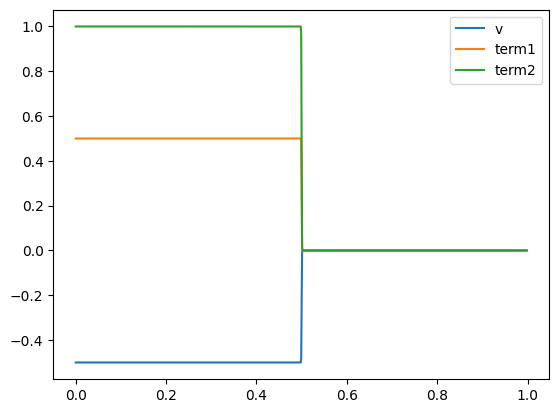

In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


gamma = 0.5
sigma = 0.1
delta_t = 0.0001
k = -1
L = 100
x = 10
y = L**2 / x
p = (y/x) / (1-gamma)**(k)
results = []

for gamma in np.arange(0.0001, 0.999, 0.001):   

    A = np.exp(-1/8 * sigma**2 * delta_t)
    d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
    integrand_plus = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
    integrand_minus = np.log(y*(1-gamma)/(p*x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2
    term1 = 0.5 * A * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = norm.cdf(d1 - sigma * np.sqrt(delta_t) / 2) + norm.cdf(-d2 - sigma * np.sqrt(delta_t) / 2)

    v = (term1 - term2)

    results.append({'gamma': gamma, 'v': v, 'term1': term1, 'term2': term2})

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt
print(f"maximum v: {results_df['v'].max()}")
plt.plot(results_df['gamma'], results_df['v'])
plt.plot(results_df['gamma'], results_df['term1'])
plt.plot(results_df['gamma'], results_df['term2'])
plt.legend(['v', 'term1', 'term2'])
plt.show()


maximum v: 1.4237032537303515e-14


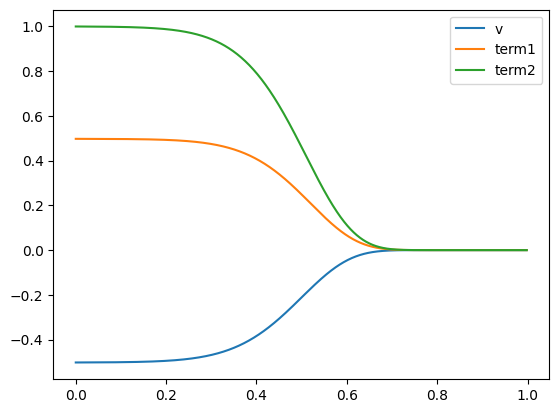

In [37]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


gamma = 0.5
sigma = 0.2
delta_t = 1
k = 1
L = 100
x = 10
y = L**2 / x
p = (y/x) / (1-gamma)**(k)
results = []

for gamma in np.arange(0.0001, 0.999, 0.001):   

    A = np.exp(-1/8 * sigma**2 * delta_t)
    d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
    integrand_plus = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
    integrand_minus = np.log(y*(1-gamma)/(p*x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2
    term1 = 0.5 * A * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = 1 + norm.cdf(d1 - sigma * np.sqrt(delta_t) / 2) - norm.cdf(d1 - (2*np.log(1-gamma)/(sigma*np.sqrt(delta_t))) + sigma * np.sqrt(delta_t) / 2)

    v = (term1 - term2)

    results.append({'gamma': gamma, 'v': v, 'term1': term1, 'term2': term2})

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt
print(f"maximum v: {results_df['v'].max()}")
plt.plot(results_df['gamma'], results_df['v'])
plt.plot(results_df['gamma'], results_df['term1'])
plt.plot(results_df['gamma'], results_df['term2'])
plt.legend(['v', 'term1', 'term2'])
plt.show()


maximum v: 0.01243710242080466


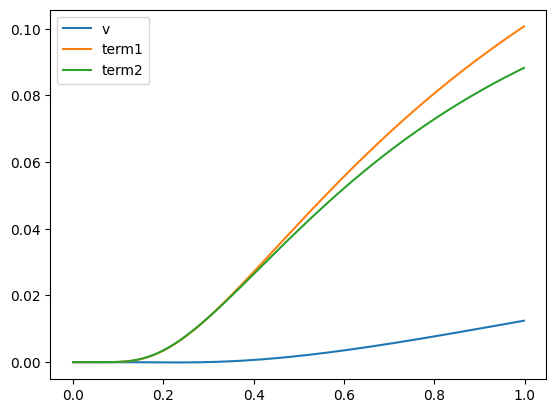

In [46]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


gamma = 0.5
sigma = 1
delta_t = 1
k = 0
L = 100
x = 10
y = L**2 / x
p = (y/x) / (1-gamma)**(k)
gamma = 0.7
results = []

for delta_t in np.arange(0.0001, 0.999, 0.001):   

    A = np.exp(-1/8 * sigma**2 * delta_t)
    d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
    integrand_plus = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
    integrand_minus = np.log(y*(1-gamma)/(p*x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2
    term1 = 0.5 * A * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = 1 + norm.cdf(d1 - sigma * np.sqrt(delta_t) / 2) - norm.cdf(d1 - (2*np.log(1-gamma)/(sigma*np.sqrt(delta_t))) + sigma * np.sqrt(delta_t) / 2)

    v = (term1 - term2)

    results.append({'delta_t': delta_t, 'v': v, 'term1': term1, 'term2': term2})

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt
print(f"maximum v: {results_df['v'].max()}")
plt.plot(results_df['delta_t'], results_df['v'])
plt.plot(results_df['delta_t'], results_df['term1'])
plt.plot(results_df['delta_t'], results_df['term2'])
plt.legend(['v', 'term1', 'term2'])
plt.show()

maximum v: 4.08138792863408e-14


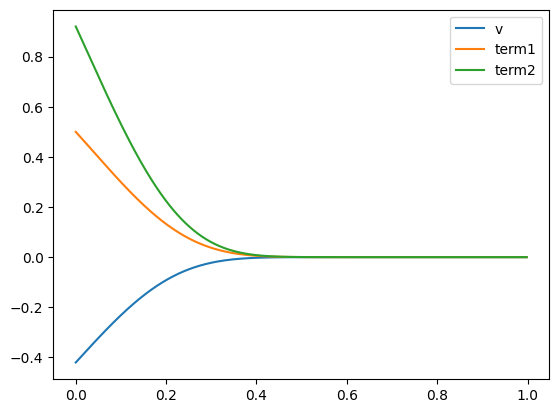

In [20]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


gamma = 0.5
sigma = 0.2
delta_t = 1
k = 0
L = 100
x = 10
y = L**2 / x
p = (y/x) / (1-gamma)**(k)
results = []

for gamma in np.arange(0.0001, 0.999, 0.001):   

    A = np.exp(-1/8 * sigma**2 * delta_t)
    d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
    integrand_plus = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
    integrand_minus = np.log(y*(1-gamma)/(p*x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2
    term1 = 0.5 * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = 1 + norm.cdf(d1 - sigma * np.sqrt(delta_t) / 2) - norm.cdf(d1 - (2*np.log(1-gamma)/(sigma*np.sqrt(delta_t))) + sigma * np.sqrt(delta_t) / 2)

    v = (term1 - term2)

    results.append({'gamma': gamma, 'v': v, 'term1': term1, 'term2': term2})

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt
print(f"maximum v: {results_df['v'].max()}")
plt.plot(results_df['gamma'], results_df['v'])
plt.plot(results_df['gamma'], results_df['term1'])
plt.plot(results_df['gamma'], results_df['term2'])
plt.legend(['v', 'term1', 'term2'])
plt.show()


p: 2.0, x: 50, y: 200.0
maximum v: 7.775200451795449e-17


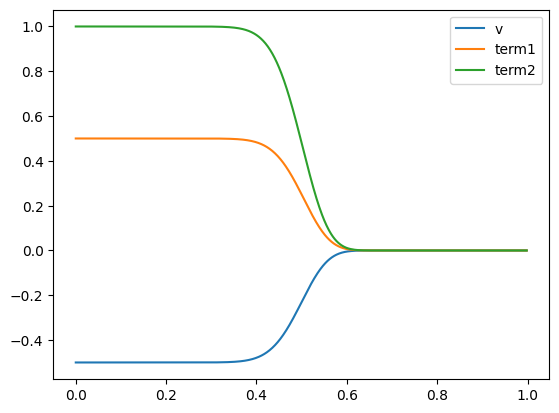

In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


gamma = 0.5
sigma = 0.1
delta_t = 1
k = -1
L = 100
x = 50
y = L**2 / x
p = (y/x) / (1-gamma)**(k)
results = []
print(f"p: {p}, x: {x}, y: {y}")
for gamma in np.arange(0.0001, 0.999, 0.001):   

    A = np.exp(-1/8 * sigma**2 * delta_t)
    d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
    integrand_plus = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
    integrand_minus = np.log(y*(1-gamma)/(p*x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2
    term1 = 0.5 * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = 1 + norm.cdf(d1 - sigma * np.sqrt(delta_t) / 2) - norm.cdf(d1 - (2*np.log(1-gamma)/(sigma*np.sqrt(delta_t))) + sigma * np.sqrt(delta_t) / 2)

    v = (term1 - term2)

    results.append({'gamma': gamma, 'v': v, 'term1': term1, 'term2': term2})

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt
print(f"maximum v: {results_df['v'].max()}")
plt.plot(results_df['gamma'], results_df['v'])
plt.plot(results_df['gamma'], results_df['term1'])
plt.plot(results_df['gamma'], results_df['term2'])
plt.legend(['v', 'term1', 'term2'])
plt.show()


p: 2.0, x: 50, y: 200.0
fee: 0.019940863189333413
maximum v: -0.10341237445326179


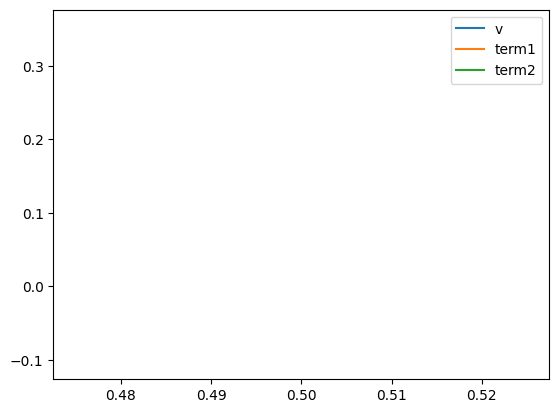

In [5]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


gamma = 0.5
sigma = 0.1
delta_t = 0.0001
k = -1
L = 100
x = 50
y = L**2 / x
p = (y/x) / (1-gamma)**(k)
results = []
print(f"p: {p}, x: {x}, y: {y}")
gammas = [0.5]
for gamma in gammas:   

    A = np.exp(-1/8 * sigma**2 * delta_t)
    d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
    d1_plus = d1 + sigma * np.sqrt(delta_t) / 2
    d1_minus = d1 - sigma * np.sqrt(delta_t) / 2
    d2_plus = d2 + sigma * np.sqrt(delta_t) / 2
    d2_minus = d2 - sigma * np.sqrt(delta_t) / 2
    term1 = 0.5 * A * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = (1/(np.sqrt((1-gamma)**k))) * (norm.cdf(d1_minus) + norm.cdf(-d2_plus))
    v = (term1 - term2)
    fee_term1 = L * np.sqrt((1-gamma)*p) * A * (norm.cdf(d1) + norm.cdf(-d2))
    fee_term2 = L * np.sqrt(p/(1-gamma)**k) * norm.cdf(d1_minus)
    fee_term3 = L * np.sqrt(p*(1-gamma)**k) * norm.cdf(-d2_plus)
    fee = (gamma/(1-gamma)) * (fee_term1 - fee_term2 - fee_term3)
    print(f"fee: {fee}")
    
    
    fee_plus = 2*L*np.sqrt(p) * (gamma/(1-gamma)) * (norm.cdf(d1_plus) - norm.cdf(d1_minus))
    results.append({'gamma': gamma, 'v': v, 'term1': term1, 'term2': term2, 'fee': fee})

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt
print(f"maximum v: {results_df['v'].max()}")
plt.plot(results_df['gamma'], results_df['v'])
plt.plot(results_df['gamma'], results_df['term1'])
plt.plot(results_df['gamma'], results_df['term2'])
plt.legend(['v', 'term1', 'term2'])
plt.show()

In [12]:
from scipy.stats import norm
import numpy as np
import sys
sys.path.append('/home/shiftpub/Dynamic_AMM/inf_step_exp/parametric_approach')
from parametric import ParametricValueModel
from CPMM import AMM


gamma = 0.5
L = 100
y = 100
x = 100
p = 1 * (1-gamma)
mu = 0.0

sigma = 0.1
delta_t = 1

amm = AMM(L=L, mu=mu, sigma=sigma, gamma=gamma, delta_t=delta_t)
lhs = 2 * L * np.sqrt(p) * (1 - np.exp(-1/8 * sigma**2 * delta_t))
print(amm.calculate_fee(p, x, y))
print(f"lhs: {lhs}")

(0.9657098150331471, 13.512555530361361, 142.7972137245833)
lhs: 0.17666625588328463


In [23]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


# gamma = 0.5
sigma = 1
delta_t = 1
k = 0
L = 100
x = 10
y = L**2 / x
p = (y/x) / (1-gamma)**(k)

gamma = 1 - np.exp(-1)

A = np.exp(-1/8 * sigma**2 * delta_t)
d1 = np.log((1-gamma) * y / (p * x)) / (sigma * np.sqrt(delta_t))
d2 = np.log(y/((1-gamma) * p * x)) / (sigma * np.sqrt(delta_t))
integrand_plus = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t)) + sigma * np.sqrt(delta_t) / 2
integrand_minus = np.log(y*(1-gamma)/(p*x)) / (sigma * np.sqrt(delta_t)) - sigma * np.sqrt(delta_t) / 2
term1 = 0.5 * A *(norm.cdf(d1) + norm.cdf(-d2))
term2 = 1 + norm.cdf(d1 - sigma * np.sqrt(delta_t) / 2) - norm.cdf(d1 - (2*np.log(1-gamma)/(sigma*np.sqrt(delta_t))) + sigma * np.sqrt(delta_t) / 2)

v = (term1 - term2)
print(f"gamma:{gamma}")

print(f"v : {v}")

gamma:0.6321205588285577
v : 0.00639836763556717


p: [2.], x: [50.], y: [200.]
incoming_term1: [49.99999375], incoming_term2: [49.98005289], incoming_term3: [0.]
incoming_fee: [0.01994086]
lhs: 0    0.000035
Name: lfs, dtype: float64 
rhs: 0    0.019941
Name: fin, dtype: float64


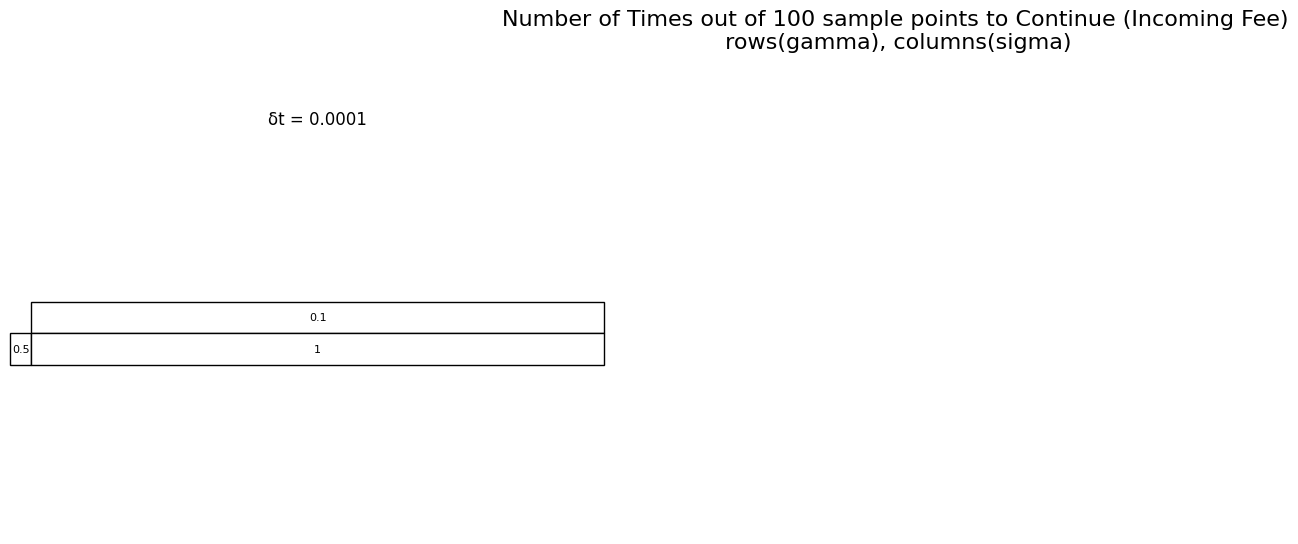

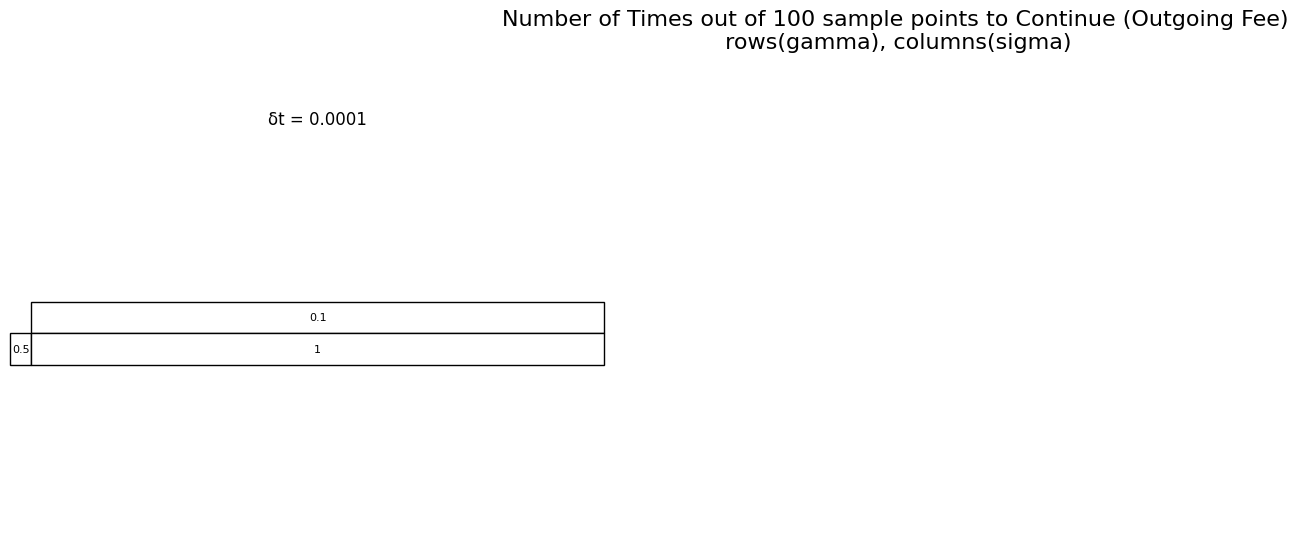

Tables created and saved as 'continue_in_tables.png' and 'continue_out_tables.png'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from parametric import ParametricValueModel
from matplotlib.gridspec import GridSpec

# Define parameter values
L = 100
mu = 0.0
sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
gamma_values = [0.5, 0.6, 0.7, 0.8, 0.9]
delta_t_values = [0.0001, 0.0004, 0.0007, 0.001, 0.004, 0.007, 0.01, 0.05, 0.1]

sigma_values = [0.1]
gamma_values = [0.5]
delta_t_values = [0.0001]

# Run parameter sweep
results = []
for sigma in sigma_values:
    for gamma in gamma_values:
        for delta_t in delta_t_values:
            model = ParametricValueModel(L=L, mu=mu, sigma=sigma, gamma=gamma, delta_t=delta_t)
            parametric_df = model.generate_raw_data(k = -1, num_samples=1)
            parametric_df.loc[:, 'L'] = L
            parametric_df.loc[:, 'lfs'] = 2 * parametric_df['L'] * np.sqrt(parametric_df['p']) * (1 - np.exp(-1/8 * sigma**2 * delta_t))
            print(f"lhs: {parametric_df['lfs']} ")
            print(f"rhs: {parametric_df['fin']}")
            # Count how many rows lfs is less than fin/fout
            num_time_to_continue_in = (parametric_df['lfs'] < parametric_df['fin']).sum()
            num_time_to_continue_out = (parametric_df['lfs'] < parametric_df['fout']).sum()
            
            results.append({
                'sigma': sigma, 
                'gamma': gamma, 
                'delta_t': delta_t, 
                'continue_in': num_time_to_continue_in, 
                'continue_out': num_time_to_continue_out
            })

# Create DataFrame
results_df = pd.DataFrame(results)

# Function to create a single table plot
def plot_table(ax, data, title):
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=data.values,
        colLabels=data.columns,
        rowLabels=data.index,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    ax.set_title(title)

# Create a 3x3 grid of tables for continue_in
plt.figure(figsize=(18, 14))
plt.suptitle('Number of Times out of 100 sample points to Continue (Incoming Fee)\n rows(gamma), columns(sigma)', fontsize=16)
gs = GridSpec(3, 3)

for i, delta_t in enumerate(delta_t_values):
    row = i // 3
    col = i % 3
    
    ax = plt.subplot(gs[row, col])
    
    # Filter for current delta_t
    df_filtered = results_df[results_df['delta_t'] == delta_t]
    
    # Create pivot table
    pivot = pd.pivot_table(
        df_filtered,
        values='continue_in',
        index='gamma',
        columns='sigma'
    )
    
    # Plot table
    plot_table(ax, pivot, f'δt = {delta_t}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('continue_in_tables.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create a 3x3 grid of tables for continue_out
plt.figure(figsize=(18, 14))
plt.suptitle('Number of Times out of 100 sample points to Continue (Outgoing Fee)\n rows(gamma), columns(sigma)', fontsize=16)
gs = GridSpec(3, 3)

for i, delta_t in enumerate(delta_t_values):
    row = i // 3
    col = i % 3
    
    ax = plt.subplot(gs[row, col])
    
    # Filter for current delta_t
    df_filtered = results_df[results_df['delta_t'] == delta_t]
    
    # Create pivot table
    pivot = pd.pivot_table(
        df_filtered,
        values='continue_out',
        index='gamma',
        columns='sigma'
    )
    
    # Plot table
    plot_table(ax, pivot, f'δt = {delta_t}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('continue_out_tables.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Tables created and saved as 'continue_in_tables.png' and 'continue_out_tables.png'")